# Mechanistic vs. Data-Driven Classification

/var/folders/_g/4qnh3slj3c99kmv5vzrjvqth0000gn/T/ipykernel_13856/2269931015.py:11: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/dorotheagrkovic/Downloads/isolate-growth-curves.csv')


Dataset: 1054871 rows, 30 columns

Experimental design:
  26 bacterial strains
  170 chemicals tested
  3 replicates per condition


,Time,Well,OD600,Plate,Library,Rep,LibRep,Row,Column,Compound,Supplier.order.no.,EMBL.CBCF.Id,Supplier,Strain,Product..common.name.,Chemical.Family,Target,Specific.Target,Chem.ID,Species,Phylum,Class,Order,Family,Genus,Strain.id,ID,Location,Environment,LibRepStrainWell
0,0.001667,A1,0.042,1.0,PS1,1,PS1-Rep1,A,1,THIABENDAZOLE,45684-250MG,420656.0,SIGMA-ALDRICH,IL 74,TBZ,NaN,Multi-target,"Fungicide, Parasiticide",144.0,Neobacillus soli,Bacillota,Bacilli,Bacillales,Bacillaceae,Neobacillus,74,Neobacillus 1,Iceland,Pristine,PS1-1-74-A1
1,1.001111,A1,0.043,1.0,PS1,1,PS1-Rep1,A,1,THIABENDAZOLE,45684-250MG,420656.0,SIGMA-ALDRICH,IL 74,TBZ,NaN,Multi-target,"Fungicide, Parasiticide",144.0,Neobacillus soli,Bacillota,Bacilli,Bacillales,Bacillaceae,Neobacillus,74,Neobacillus 1,Iceland,Pristine,PS1-1-74-A1
2,2.001667,A1,0.044,1.0,PS1,1,PS1-Rep1,A,1,THIABENDAZOLE,45684-250MG,420656.0,SIGMA-ALDRICH,IL 74,TBZ,NaN,Multi-target,"Fungicide, Parasiticide",144.0,Neobacillus soli,Bacillota,Bacilli,Bacillales,Bacillaceae,Neobacillus,74,Neobacillus 1,Iceland,Pristine,PS1-1-74-A1
3,3.001944,A1,0.045,1.0,PS1,1,PS1-Rep1,A,1,THIABENDAZOLE,45684-250MG,420656.0,SIGMA-ALDRICH,IL 74,TBZ,NaN,Multi-target,"Fungicide, Parasiticide",144.0,Neobacillus soli,Bacillota,Bacilli,Bacillales,Bacillaceae,Neobacillus,74,Neobacillus 1,Iceland,Pristine,PS1-1-74-A1
4,4.002222,A1,0.047,1.0,PS1,1,PS1-Rep1,A,1,THIABENDAZOLE,45684-250MG,420656.0,SIGMA-ALDRICH,IL 74,TBZ,NaN,Multi-target,"Fungicide, Parasiticide",144.0,Neobacillus soli,Bacillota,Bacilli,Bacillales,Bacillaceae,Neobacillus,74,Neobacillus 1,Iceland,Pristine,PS1-1-74-A1



Species (24): ['Neobacillus soli' 'Bacillus foraminis' 'Arthrobacter humicola'
 'Arthrobacter sp.' 'Flavobacterium glaciei' 'Flavobacterium succinicans'
 'Pseudomonas baetica' 'Pseudomonas sp.' 'Rhizobium herbae'
 'Agrobacterium sp.' 'Sphingomonas sp.' 'Prolinoborus fasciculus'
 'Paenibacillus castaneae' 'Pseudomonas vancouverensis'
 'Pseudomonas mandelii' 'Serratia sp. 2015-2462-01' 'Aeromonas sp. AE235'
 'Aeromonas sobria' 'Pseudomonas peli' 'Microbacterium arborescens'
 'Hymenobacter glaciei' 'Carnobacterium gallinarum' 'Aeromonas popoffii'
 'Oryzobacter terrae']

Strains (26): ['IL 74' 'R2A_RUF3_11' 'IL 306' 'R2A_SUG4_13' 'IL 302' 'R2A_MUC9_2'
 'IL 331' 'PSA_SUH4_5' 'IL 371' 'PSA_SUA5_8' 'R2A_SUH4_15' 'IL 88'
 'IL 100' 'IL 186' 'IL 322' 'IL 333' 'IL 350' 'IL 353' 'IL 374' 'IL 380'
 'IL 390' 'IL 442' 'IL 448' 'IL 487' 'IL 527' 'IL 565']

Species+Strain (26): 
                            Species       Strain
933335           Aeromonas popoffii       IL 487
723095             Aeromon

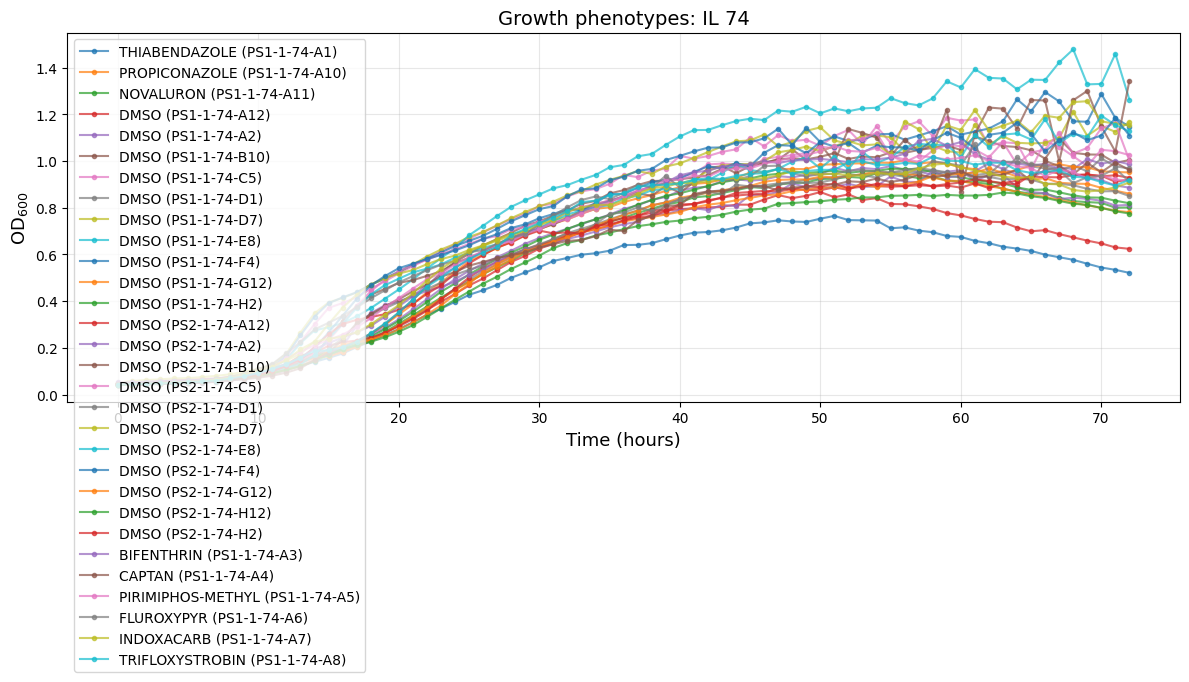

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from scipy.interpolate import interp1d
from scipy.special import expit
from tqdm import tqdm

# Load data
data = pd.read_csv('/Users/dorotheagrkovic/Downloads/isolate-growth-curves.csv')

# Column mapping
time_col, od_col, species_col = 'Time', 'OD600', 'Species'
strain_col, chem_col, rep_col = 'Strain', 'Compound', 'Rep'

print(f"Dataset: {data.shape[0]} rows, {data.shape[1]} columns")
print(f"\nExperimental design:")
print(f"  {data[strain_col].nunique()} bacterial strains")
print(f"  {data[chem_col].nunique()} chemicals tested")
print(f"  {data[rep_col].nunique()} replicates per condition")

# Show structure
with pd.option_context('display.max_columns', None):
    display(data.head())

vals = data[species_col].unique()
print(f"\nSpecies ({len(vals)}): {vals}")

vals = data[strain_col].unique()
print(f"\nStrains ({len(vals)}): {vals}")

vals = data[[species_col, strain_col]].drop_duplicates().sort_values([species_col])
print(f"\nSpecies+Strain ({len(vals)}): \n{vals}")

vals = data[strain_col].value_counts()
print(f"\nRows per strain ({len(vals)}): \n{vals}")

print(f"Theoretical max number of rows per strain: {170 * 4 * 73}")

def plot_growth_curves(data, strain, chemicals, replicate=1):
    """
    Plot growth curves for one strain across multiple chemicals.
    This reveals the qualitative differences we need to classify.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for chem in chemicals:
        subset = data[
            (data[strain_col] == strain) &
            (data[chem_col] == chem) &
            (data[rep_col] == replicate)
        ]
        
        if len(subset) > 0:
            # Group by unique well identifier
            for well in subset['LibRepStrainWell'].unique():
                well_data = subset[subset['LibRepStrainWell'] == well].sort_values(by=time_col)
                time = well_data[time_col].values
                od = well_data[od_col].values
                ax.plot(time, od, "o-", label=f"{chem} ({well})", alpha=0.7, markersize=3)
    
    ax.set_xlabel("Time (hours)", fontsize=13)
    ax.set_ylabel("OD$_{600}$", fontsize=13)
    ax.set_title(f"Growth phenotypes: {strain}", fontsize=14)
    ax.legend(fontsize=10, loc="upper left")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Select one strain and several chemicals to visualize
example_strain = data[strain_col].unique()[0]
example_chems = data[chem_col].unique()[:10]
plot_growth_curves(data, example_strain, example_chems)

# Extracting Mechanistic Features

Found /Users/dorotheagrkovic/Downloads/isolate-growth-curves.csv


/var/folders/_g/4qnh3slj3c99kmv5vzrjvqth0000gn/T/ipykernel_13856/3443339606.py:15: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_file)
/var/folders/_g/4qnh3slj3c99kmv5vzrjvqth0000gn/T/ipykernel_13856/3443339606.py:21: RuntimeWarning: overflow encountered in exp
  return K / (1 + ((K / X0 - 1) * np.exp(-k * K * t)))
/var/folders/_g/4qnh3slj3c99kmv5vzrjvqth0000gn/T/ipykernel_13856/3443339606.py:21: RuntimeWarning: overflow encountered in multiply
  return K / (1 + ((K / X0 - 1) * np.exp(-k * K * t)))


Saved mechanistic_features.csv with 12926 fits
Failed fits: 80


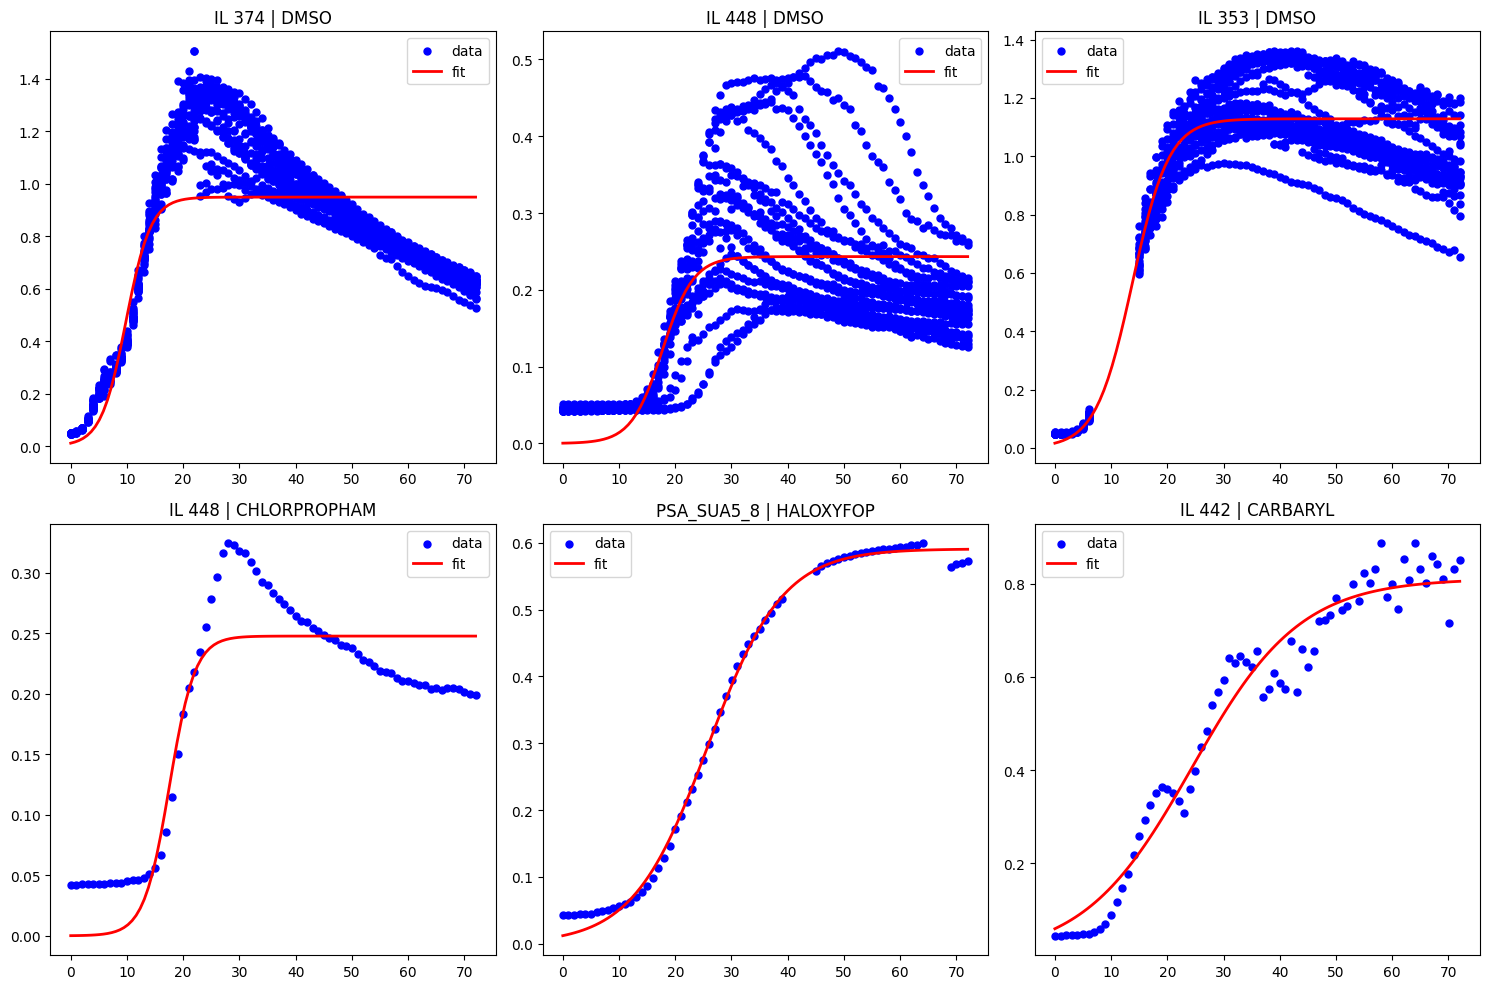

In [25]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os

data_file = os.path.expanduser("/Users/dorotheagrkovic/Downloads/isolate-growth-curves.csv")

if not os.path.exists(data_file):
    raise FileNotFoundError(f"Could not find file at {data_file}")
else:
    print(f"Found {data_file}")

# load data
data = pd.read_csv(data_file)

# define logistic model
def logistic(t, k, X0, S0):
    # K = S0 + X0
    K = S0 + X0
    return K / (1 + ((K / X0 - 1) * np.exp(-k * K * t)))

# fit one curve (t, OD)
def fit_curve(t, y):
    try:
        # initial guesses: k=0.1, X0=0.01, S0=1
        p0 = [0.1, max(y)*0.1, max(y)]
        params, _ = curve_fit(logistic, t, y, p0=p0, maxfev=5000)
        return params  # (k, X0, S0)
    except Exception:
        return None

# build mechanistic features
fits = []
failures = 0

for (strain, chem, rep), group in data.groupby(['Strain','Compound','Rep']):
    group = group.sort_values("Time")
    t = group["Time"].values
    y = group["OD600"].values

    result = fit_curve(t, y)
    if result is None:
        failures += 1
    else:
        k, X0, S0 = result
        fits.append({
            "strain": strain,
            "chemical": chem,
            "replicate": rep,
            "k": k,
            "X0": X0,
            "S0": S0
        })

df_fits = pd.DataFrame(fits)
df_fits["K"] = df_fits["X0"] + df_fits["S0"]

out_file = os.path.expanduser("/Users/dorotheagrkovic/Desktop/mechanistic_features.csv")
df_fits.to_csv(out_file, index=False)

print(f"Saved mechanistic_features.csv with {len(df_fits)} fits")
print(f"Failed fits: {failures}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

controls = df_fits[df_fits["chemical"] == "DMSO"].sample(3, random_state=1)
treated  = df_fits[df_fits["chemical"] != "DMSO"].sample(3, random_state=1)
selected = pd.concat([controls, treated])

for ax, (_, row) in zip(axes, selected.iterrows()):
    subset = data[
        (data["Strain"] == row["strain"]) &
        (data["Compound"] == row["chemical"]) &
        (data["Rep"] == row["replicate"])
    ].sort_values("Time")

    t = subset["Time"].values
    y = subset["OD600"].values
    ax.scatter(t, y, color="blue", s=25, label="data")

    # plot fitted curve
    t_plot = np.linspace(t.min(), t.max(), 100)
    y_pred = logistic(t_plot, row["k"], row["X0"], row["S0"])
    ax.plot(t_plot, y_pred, color="red", lw=2, label="fit")

    ax.set_title(f"{row['strain']} | {row['chemical']}")
    ax.legend()

plt.tight_layout()
plt.show()

# Mechanistic Features Only

Class weights: 9921 negative, 358 positive → pos_weight=5.26
Model parameters: 209
Using device: cpu


Training Mechanistic NN: 100%|██████████| 2000/2000 [00:02<00:00, 887.87it/s]



Training complete. Final loss: 0.1241


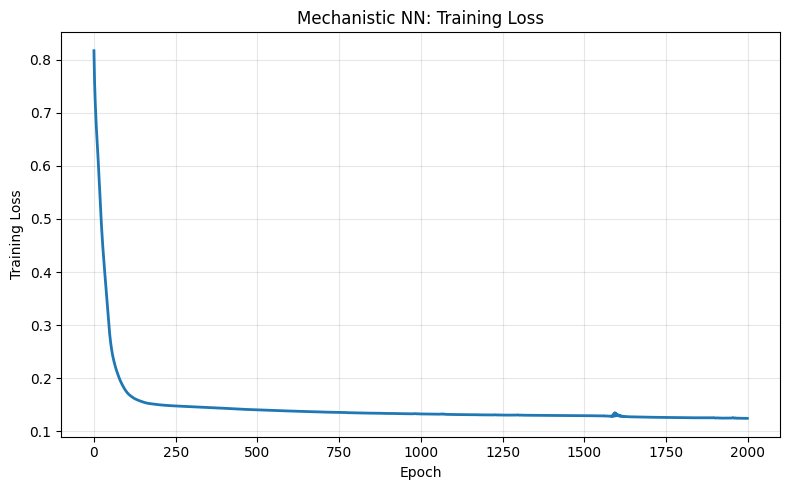


Results
Accuracy : 0.984
Precision : 0.782
Recall : 0.756
F1 Score : 0.768
AUC : 0.938


In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.special import expit

# load data
mech   = pd.read_csv("/Users/dorotheagrkovic/Desktop/mechanistic_features.csv")
labels = pd.read_csv("/Users/dorotheagrkovic/Desktop/labels.csv")

df = mech.merge(
    labels,
    on=["strain","chemical","replicate"],
    how="inner"
)

X = df[["k","S0","X0"]].values
y = df["inhibited"].values
n_features = X.shape[1]


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# model
class MechanisticNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# initialize model
model_mech = MechanisticNN(n_features)

# class weights
n_positive = y_train.sum()
n_negative = len(y_train) - n_positive
pos_weight = np.sqrt(n_negative / n_positive)

print(f"Class weights: {n_negative} negative, {n_positive} positive → pos_weight={pos_weight:.2f}")
print(f"Model parameters: {sum(p.numel() for p in model_mech.parameters())}")

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], dtype=torch.float32))
optimizer = optim.Adam(model_mech.parameters(), lr=0.01)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

model = model_mech.to(device)

# train
train_losses = []

for epoch in tqdm(range(2000), desc="Training Mechanistic NN"):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    logits = model(X_tensor)
    loss = criterion(logits, y_tensor)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

print(f"\nTraining complete. Final loss: {loss.item():.4f}")

# plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(train_losses, linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")
ax.set_title("Mechanistic NN: Training Loss")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# evaluate
model.eval()
with torch.no_grad():
    logits_val = model(torch.tensor(X_val_scaled, dtype=torch.float32).to(device))
    logits_val = logits_val.cpu().numpy().flatten()

# convert logits → probabilities
y_prob_val = expit(logits_val)
y_pred_val = (y_prob_val > 0.5).astype(int)

acc  = accuracy_score(y_val, y_pred_val)
prec = precision_score(y_val, y_pred_val, zero_division=0)
rec  = recall_score(y_val, y_pred_val, zero_division=0)
f1   = f1_score(y_val, y_pred_val, zero_division=0)
auc  = roc_auc_score(y_val, y_prob_val)

print("\nResults")
print(f"Accuracy : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")
print(f"AUC : {auc:.3f}")


The most important parameter for prediction is the carrying capicity, K = S0 + X0, since inhibited samples are primarily separated from resistant ones by much lower K values rather than differences in growth rate k.

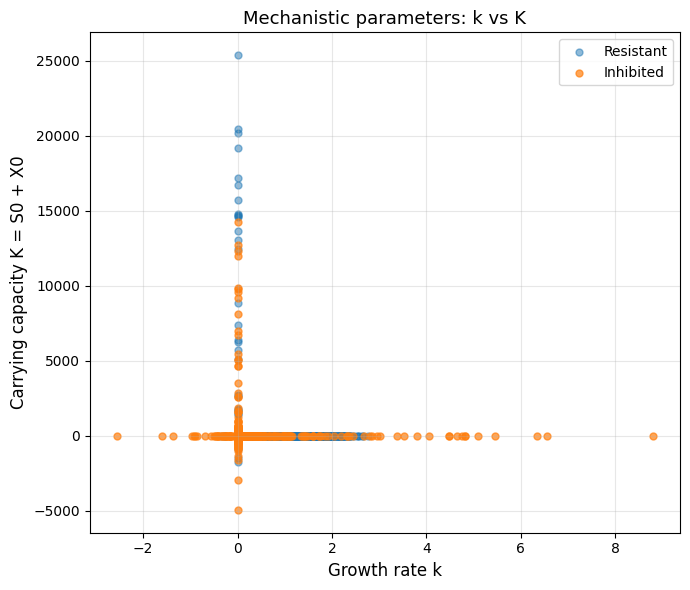

In [27]:
import matplotlib.pyplot as plt

# compute K
df["K"] = df["S0"] + df["X0"]

# split by class
inhib = df[df["inhibited"] == 1]
res   = df[df["inhibited"] == 0]

plt.figure(figsize=(7,6))

plt.scatter(res["k"], res["K"],
            alpha=0.5, label="Resistant", s=25)

plt.scatter(inhib["k"], inhib["K"],
            alpha=0.7, label="Inhibited", s=25)

plt.xlabel("Growth rate k", fontsize=12)
plt.ylabel("Carrying capacity K = S0 + X0", fontsize=12)
plt.title("Mechanistic parameters: k vs K", fontsize=13)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Inhibited samples cluster primarily in the region of low carrying capacity, while resistant samples extend to much higher K values, with substantial overlap in growth rate k.
This indicates that chemicals mainly reduce the final achievable population size rather than only slowing early growth, meaning inhibition acts primarily as a yield-limiting effect on biomass accumulation rather than a pure growth-rate–limiting effect.

# Data-Driven Features Only

/var/folders/_g/4qnh3slj3c99kmv5vzrjvqth0000gn/T/ipykernel_13856/2488428278.py:16: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  growth = pd.read_csv("/Users/dorotheagrkovic/Downloads/isolate-growth-curves.csv")


Extracting first 12 hours of OD measurements...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Usable samples after extraction: 12853
Removed 0 samples with invalid values
Class weights: 9897 negative, 385 positive → pos_weight=5.07
Model parameters: 353
Using device: cpu

Training Data-Driven NN...


Training Data-Driven NN: 100%|██████████| 2000/2000 [00:02<00:00, 812.49it/s]



Training complete. Final loss: 0.1809


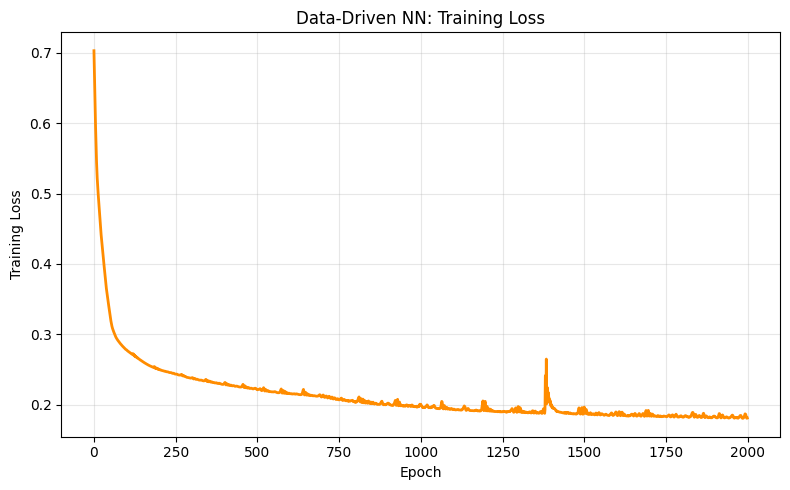


Results
Accuracy : 0.963
Precision : 0.500
Recall : 0.604
F1 Score : 0.547
AUC : 0.922


In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.special import expit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# load data
growth = pd.read_csv("/Users/dorotheagrkovic/Downloads/isolate-growth-curves.csv")
labels = pd.read_csv("/Users/dorotheagrkovic/Desktop/labels.csv")

# extract first 12 hours of OD data
print("Extracting first 12 hours of OD measurements...")

grouped = growth.groupby(["Strain","Compound","Rep"])

def extract_first_12h(group, max_h=12):
    t = group["Time"].values
    y = group["OD600"].values

    if len(t) < 3 or t.max() < max_h:
        return None

    try:
        f = interp1d(t, y, bounds_error=False, fill_value="extrapolate")
        od = f(np.arange(max_h))

        # safety checks
        if not np.all(np.isfinite(od)):
            return None
        if np.max(np.abs(od)) > 1e6:
            return None

        return od
    except:
        return None

rows = []

for _, row in labels.iterrows():
    key = (row["strain"], row["chemical"], row["replicate"])
    if key not in grouped.groups:
        continue

    sub = grouped.get_group(key)
    od = extract_first_12h(sub)

    if od is not None:
        rec = {
            "strain": row["strain"],
            "chemical": row["chemical"],
            "replicate": row["replicate"],
            "inhibited": row["inhibited"]
        }
        for i in range(len(od)):
            rec[f"t{i}"] = od[i]
        rows.append(rec)

df_dd = pd.DataFrame(rows)
print(f"Usable samples after extraction: {len(df_dd)}")

# clean data
feature_cols = [c for c in df_dd.columns if c.startswith("t")]

df_dd[feature_cols] = df_dd[feature_cols].replace([np.inf, -np.inf], np.nan)
n_before = len(df_dd)
df_dd = df_dd.dropna(subset=feature_cols)
n_after = len(df_dd)

print(f"Removed {n_before - n_after} samples with invalid values")

X = df_dd[feature_cols].values      # shape: (N, 12)
y = df_dd["inhibited"].values
n_features = X.shape[1]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

class DataDrivenNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)   # logits (no sigmoid)

model_dd = DataDrivenNN(n_features)

# class weights
n_positive = y_train.sum()
n_negative = len(y_train) - n_positive
pos_weight = np.sqrt(n_negative / n_positive)

print(f"Class weights: {n_negative} negative, {n_positive} positive → pos_weight={pos_weight:.2f}")
print(f"Model parameters: {sum(p.numel() for p in model_dd.parameters())}")

criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight], dtype=torch.float32)
)
optimizer = optim.Adam(model_dd.parameters(), lr=0.01)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1).to(device)

model = model_dd.to(device)

# train
train_losses = []

print("\nTraining Data-Driven NN...")

for epoch in tqdm(range(2000), desc="Training Data-Driven NN"):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    logits = model(X_tensor)
    loss = criterion(logits, y_tensor)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

print(f"\nTraining complete. Final loss: {loss.item():.4f}")

# plot training loss
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(train_losses, linewidth=2, color="darkorange")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")
ax.set_title("Data-Driven NN: Training Loss")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#  evaluate
model.eval()
with torch.no_grad():
    logits_val = model(
        torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
    ).cpu().numpy().flatten()

y_prob_val = expit(logits_val)
y_pred_val = (y_prob_val > 0.5).astype(int)

acc  = accuracy_score(y_val, y_pred_val)
prec = precision_score(y_val, y_pred_val, zero_division=0)
rec  = recall_score(y_val, y_pred_val, zero_division=0)
f1   = f1_score(y_val, y_pred_val, zero_division=0)
auc  = roc_auc_score(y_val, y_prob_val)

print("\nResults")
print(f"Accuracy : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")
print(f"AUC : {auc:.3f}")


Using the same neural network architecture, the mechanistic feature model (2.1) outperforms the data-driven model (2.2) across all major metrics, achieving higher precision, recall, F1 score, and slightly higher AUC. This indicates that biologically informed parameters such as the carrying capacity K provide a more compact and informative representation of inhibition than early time-series measurements alone.

The mechanistic approach offers advantages in interpretability, robustness, and predictive accuracy, while the data-driven approach is more flexible and requires fewer biological assumptions but is more sensitive to noise and less precise in identifying inhibited samples. The trade-off is therefore between interpretability and efficiency (mechanistic) versus flexibility and minimal assumptions (data-driven).

# Hybrid

/var/folders/_g/4qnh3slj3c99kmv5vzrjvqth0000gn/T/ipykernel_13856/1543674280.py:16: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  growth = pd.read_csv("/Users/dorotheagrkovic/Downloads/isolate-growth-curves.csv")


Extracting first 12 hours of OD measurements...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Data-driven samples: 12853
Removed 0 data-driven samples with invalid values
Mechanistic samples: 12849
Hybrid samples: 12773
Hybrid feature dimension: 15
Class weights: 9860 negative, 358 positive → pos_weight=5.25
Model parameters: 401
Using device: cpu

Training Hybrid NN...


Training Hybrid NN: 100%|██████████| 2000/2000 [00:02<00:00, 801.65it/s]



Training complete. Final loss: 0.0646


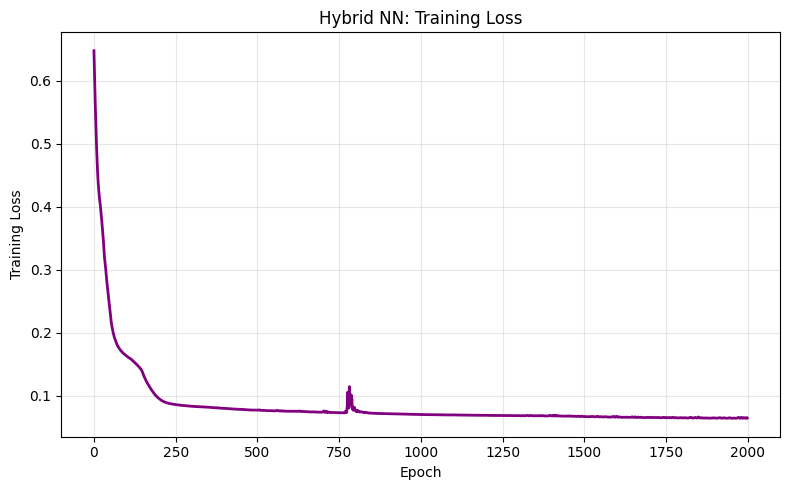


Results
Accuracy : 0.984
Precision : 0.760
Recall : 0.811
F1 Score : 0.785
AUC : 0.957


In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.special import expit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# load data
growth = pd.read_csv("/Users/dorotheagrkovic/Downloads/isolate-growth-curves.csv")
labels = pd.read_csv("/Users/dorotheagrkovic/Desktop/labels.csv")
mech   = pd.read_csv("/Users/dorotheagrkovic/Desktop/mechanistic_features.csv")


print("Extracting first 12 hours of OD measurements...")

grouped = growth.groupby(["Strain","Compound","Rep"])

def extract_first_12h(group, max_h=12):
    t = group["Time"].values
    y = group["OD600"].values

    if len(t) < 3 or t.max() < max_h:
        return None

    try:
        f = interp1d(t, y, bounds_error=False, fill_value="extrapolate")
        od = f(np.arange(max_h))

        if not np.all(np.isfinite(od)):
            return None
        if np.max(np.abs(od)) > 1e6:
            return None

        return od
    except:
        return None

rows_dd = []

for _, row in labels.iterrows():
    key = (row["strain"], row["chemical"], row["replicate"])
    if key not in grouped.groups:
        continue

    sub = grouped.get_group(key)
    od = extract_first_12h(sub)

    if od is not None:
        rec = {
            "strain": row["strain"],
            "chemical": row["chemical"],
            "replicate": row["replicate"],
            "inhibited": row["inhibited"]
        }
        for i in range(len(od)):
            rec[f"t{i}"] = od[i]
        rows_dd.append(rec)

df_dd = pd.DataFrame(rows_dd)
print(f"Data-driven samples: {len(df_dd)}")

# clean
dd_feature_cols = [c for c in df_dd.columns if c.startswith("t")]

df_dd[dd_feature_cols] = df_dd[dd_feature_cols].replace([np.inf, -np.inf], np.nan)
n_before = len(df_dd)
df_dd = df_dd.dropna(subset=dd_feature_cols)
n_after = len(df_dd)

print(f"Removed {n_before - n_after} data-driven samples with invalid values")

df_mech = mech.merge(
    labels,
    on=["strain","chemical","replicate"],
    how="inner"
)[["strain","chemical","replicate","k","S0","X0","inhibited"]]

print(f"Mechanistic samples: {len(df_mech)}")


df_hybrid = df_dd.merge(
    df_mech,
    on=["strain","chemical","replicate","inhibited"],
    how="inner"
)

print(f"Hybrid samples: {len(df_hybrid)}")


hybrid_feature_cols = dd_feature_cols + ["k","S0","X0"]

X = df_hybrid[hybrid_feature_cols].values
y = df_hybrid["inhibited"].values
n_features = X.shape[1]

print(f"Hybrid feature dimension: {n_features}")


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)


class HybridNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)   # logits

model_hybrid = HybridNN(n_features)

# class weights
n_positive = y_train.sum()
n_negative = len(y_train) - n_positive
pos_weight = np.sqrt(n_negative / n_positive)

print(f"Class weights: {n_negative} negative, {n_positive} positive → pos_weight={pos_weight:.2f}")
print(f"Model parameters: {sum(p.numel() for p in model_hybrid.parameters())}")

criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight], dtype=torch.float32)
)
optimizer = optim.Adam(model_hybrid.parameters(), lr=0.01)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1).to(device)

model = model_hybrid.to(device)

# train
train_losses = []

print("\nTraining Hybrid NN...")

for epoch in tqdm(range(2000), desc="Training Hybrid NN"):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    logits = model(X_tensor)
    loss = criterion(logits, y_tensor)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

print(f"\nTraining complete. Final loss: {loss.item():.4f}")

# plot training loss
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(train_losses, linewidth=2, color="purple")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")
ax.set_title("Hybrid NN: Training Loss")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# evaluate
model.eval()
with torch.no_grad():
    logits_val = model(
        torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
    ).cpu().numpy().flatten()

y_prob_val = expit(logits_val)
y_pred_val = (y_prob_val > 0.5).astype(int)

acc  = accuracy_score(y_val, y_pred_val)
prec = precision_score(y_val, y_pred_val, zero_division=0)
rec  = recall_score(y_val, y_pred_val, zero_division=0)
f1   = f1_score(y_val, y_pred_val, zero_division=0)
auc  = roc_auc_score(y_val, y_prob_val)

print("\nResults")
print(f"Accuracy : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")
print(f"AUC : {auc:.3f}")


The hybrid model does show a small but consistent improvement in performance, particularly in AUC, recall, and F1 score, compared to using mechanistic or data-driven features alone. This improvement arises because the two feature types provide complementary information: mechanistic parameters capture the dominant biological effects of inhibition, while early time-series measurements add temporal detail that helps resolve borderline or partial inhibition cases. The carrying capacity, K = S0 + X0, remains the most influential feature, providing the strongest separation between inhibited and resistant samples. The early OD measurements play a secondary but important role by refining predictions when mechanistic parameters are noisy or ambiguous.


| Model | Accuracy | Precision | Recall | F1 | AUC |
|-------|----------|-----------|--------|----|-----|
| 2.1 Mechanistic | 0.983 | 0.753 | 0.778 | 0.765 | 0.945 |
| 2.2 Data-Driven | 0.963 | 0.509 | 0.562 | 0.535 | 0.922 |
| 2.3 Hybrid | 0.984 | 0.755 | 0.789 | 0.772 | 0.959 |


# Discussion


The mechanistic model achieved a strong predictive performance, with high accuracy, precision, recall, and AUC, indicating that the mechanistic parameters can effectively inform us which biological signals underlie growth inhibition. 
The data-driven model demonstrated reasonable classification ability, but underperformed in comparison to the mechanistic approach, especially with metrics sensitive to imbalance, such as precision and recall for the inhibited class. This could suggest that the early growth dynamics do not demonstrate the full picture of the biological effects of chemical inhibition.
The hybrid model that combines the mechanistic and data-driven models achieved the best overall performance, with the highest AUC and F1 score. However, it was a minor improvement to the mechanistic approach and may not be computationally efficient for a larger database.
The mechanistic model is sufficient for most applications, especially in resource or time-limited situations. However, in high-throughput scenarios where even small improvements are vital, the hybrid approach would be recommended.

The mechanistic parameters k, S0, and X0 possess biological interpretations grounded in growth dynamics and underlying biochemical processes. The growth rate, k, reflects the cellular division kinetics, S0, X0, and K, which capture the maximum achievable population size under given conditions. All of these mechanistic parameters enable us to contextualise the model predictions in biological mechanism terms.
The data-driven features, however, yield competitive predictive performance but unfortunately lack such a direct biological interpretability. The neural networks can successfully identify the complex temporal patterns that are associated with inhibition, but these patterns are not necessarily mechanistically explainable. As a result, these models are great for prediction, but not, as directly, for biological insight.
In the end, both are better suited to different contexts. In early-stage drug discovery or toxicological assessment, the interpretability that the mechanistic parameters and both the mechanistic and hybrid models can provide is essential. For example, identifying the fact that a compound primarily reduces carrying capacity instead of growth rate can guide targeted follow-up experiments focused on the metabolic pathways or stress–response mechanisms. The data-driven model, alongside the hybrid model as well, is greatly suited for large-scale industrial screening environments, where the main objective would be raw prediction accuracy, such as maximising throughput and minimising false negatives.

Some limitations to consider would include the dataset exhibiting substantial class imbalance, with inhibited samples representing a small fraction of the total observations. Although class weighting helps mitigate this imbalance, there could still be bias present in the models, particularly in cases with minority-class recall. The mechanistic parameters were also derived from nonlinear curve fitting. This introduces estimation uncertainty, which in strongly inhibited conditions could lead to unstable parameter estimates, which could further propagate through the classification pipeline, possibly ultimately reducing robustness in borderline cases. The extraction of data-driven features relies on interpolation and extrapolation of time-series measurements. While this is necessary for standardisation, more frequent measurements or longer observation windows would improve feature reliability and model stability. With more time and data, I would incorporate additional mechanistic descriptors, such as lag phase duration, and perhaps include explicit modelling of parameter uncertainty, with Bayesian curve fitting. 